In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from collections import namedtuple
from functools import partial

from jax import random
from jax.experimental.stax import Relu, Sigmoid, Elu, Selu
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from jax_nn import create_mlp, fit, binary_crossentropy_loss, mse_loss
from jax_vae import fit as fit_vae
from jax_vae import generate_samples
from revise import Revise

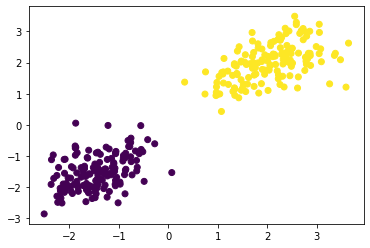

In [ ]:
c_means = [[-1.5, -1.5], [2.0, 2.0]]
c_var = 0.30**2
x_var = 1e-2

np.random.seed(0)
indices = np.random.randint(2, size=300)
samples = [
    np.random.multivariate_normal(c_means[i], c_var * np.eye(2) + 0.2 * np.ones((2, 2))) + 
           np.random.multivariate_normal(np.zeros(2), x_var**0.5 * np.eye(2)) 
           for i in indices]

x_train = np.array(samples)
plt.scatter(x_train[:, 0], x_train[:, 1], c=indices)
plt.show()

## Classification

In [ ]:
data = (x_train, indices.reshape(-1, 1))
rng_key = random.PRNGKey(0)
# We're not batching anything, so shapes of inputs and outputs are just shapes of data
input_dim = 2
output_dim = 1
hidden_widths = [6]
init_model, predict = create_mlp(hidden_widths, Relu, output_dim, Sigmoid)
output_shape, start_params = init_model(rng_key, (-1, input_dim))
(min_loss, fit_params), history = fit(predict, binary_crossentropy_loss, start_params, data, step_size=1e-2, max_iter=200)

In [ ]:
history = pd.DataFrame(history, columns=['loss', 'grad_norm'], dtype='float32')
history

,loss,grad_norm
0,0.685108,0.689037
1,0.646065,0.644802
2,0.608912,0.601674
3,0.573524,0.561199
4,0.539805,0.523525
...,...,...
195,0.003322,0.006657
196,0.003295,0.006605
197,0.003268,0.006554
198,0.003242,0.006504


<AxesSubplot:>

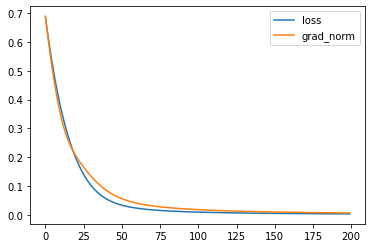

In [ ]:
history.plot.line()

In [ ]:
class_df = pd.DataFrame({'true': indices == 1, 'pred': predict(fit_params, x_train)[:,0] > 0.5})
class_df

,true,pred
0,False,False
1,True,True
2,True,True
3,False,False
4,True,True
...,...,...
295,False,False
296,False,False
297,False,False
298,True,True


In [ ]:
(class_df['true'] == class_df['pred']).mean()

1.0

## Regression

In [ ]:
data = (x_train, x_train)
rng_key = random.PRNGKey(0)
# We're not batching anything, so shapes of inputs and outputs are just shapes of data
input_dim = 2
output_dim = 2
hidden_widths = [100]
init_model, predict = create_mlp(hidden_widths, Relu, output_dim)
output_shape, start_params = init_model(rng_key, (-1, input_dim))
model = (predict, mse_loss)
fit_params, history = fit(model, start_params, data, step_size=1e-1, max_iter=200)

In [ ]:
history = pd.DataFrame(history, columns=['loss', 'grad_norm'], dtype='float32')
history

,loss,grad_norm
0,3.183546,3.768245
1,4.161569,6.616199
2,0.188818,1.059701
3,2.245172,3.217655
4,0.970969,1.580503
...,...,...
195,0.000054,0.000123
196,0.000054,0.000119
197,0.000054,0.000109
198,0.000053,0.000097


<AxesSubplot:>

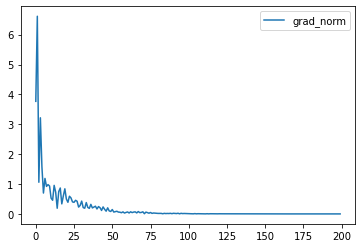

In [ ]:
history.plot.line(y='grad_norm')

<AxesSubplot:>

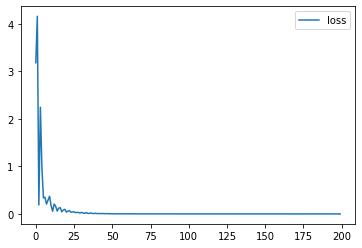

In [ ]:
history.plot.line(y='loss')

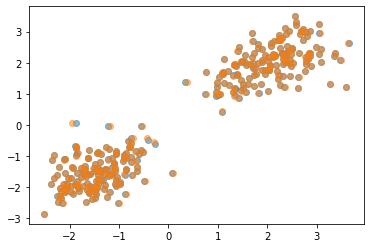

In [ ]:
regress_df = pd.DataFrame(x_train).join(pd.DataFrame(predict(fit_params, x_train)), lsuffix='_true')
plt.scatter(regress_df['0_true'], regress_df['1_true'], alpha=0.5)
plt.scatter(regress_df['0'], regress_df['1'], alpha=0.5)

In [ ]:
%debug

> <ipython-input-188-8b20d831becf>(1)<module>()
----> 1 data = (x_train[:2,:], indices[:2,:])
      2 rng_key = random.PRNGKey(0)
      3 # We're not batching anything, so shapes of inputs and outputs are just shapes of data
      4 input_dim = 2
      5 output_dim = 1



ipdb>  q


In [ ]:
%debug

## Testing VAE

In [ ]:
rng_key = random.PRNGKey(0)
data = x_train
data_vari = x_var

enc_input_dim = 2
latent_dim = 2
hidden_widths = [50]
init_model, encode = create_mlp(hidden_widths, Relu, latent_dim * 2)
enc_output_shape, enc_start_params = init_model(rng_key, (-1, enc_input_dim))

dec_input_dim = 2
dec_output_dim = 2
hidden_widths = [50]
init_model, decode = create_mlp(hidden_widths, Relu, dec_output_dim)
dec_output_shape, dec_start_params = init_model(rng_key, (-1, dec_input_dim))

In [ ]:
model = (encode, decode)
start_params = (enc_start_params, dec_start_params)
(min_loss, fit_params), history = fit_vae(rng_key, model, start_params, 
                              data, data_vari, step_size=1e-2, max_iter=5000)

,loss
0,371.004700
1,338.431946
2,314.057678
3,282.336456
4,242.195099
...,...
4995,2.394976
4996,2.385560
4997,2.401021
4998,2.398031


DeviceArray(2.3805988, dtype=float32)

<AxesSubplot:>

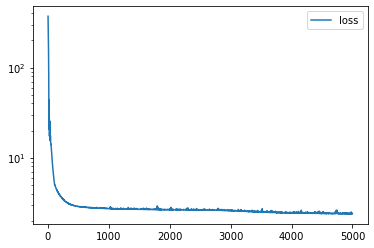

In [ ]:
vae_history = pd.DataFrame({'loss': [float(h[0]) for h in history]})
display(vae_history)
display(min_loss)
vae_history.plot.line(logy=True)

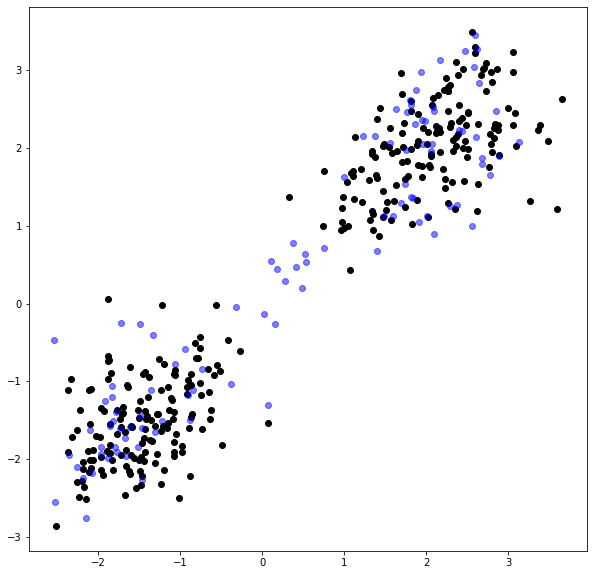

In [ ]:
x_hat = generate_samples(model, fit_params, rng_key).T
x_hat = x_hat + np.random.normal(0, x_var**0.5, size=x_hat.shape)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(x_train.T[0], x_train.T[1], color='black')
ax.scatter(x_hat[0], x_hat[1], color='blue', alpha=0.5)

plt.show()

classifier
 * predict_proba

vae
 * infer
 * encoder.forward
 * decoder.forward

## Setting up REVISE

In [ ]:
Classifier = namedtuple('Classifier', ['predict'])
VAE = namedtuple('VAE', ['encode', 'decode', 'generate', 'n_latent_dims', 'x_var'])

In [ ]:
rng_key = random.PRNGKey(0)

data = (x_train, indices.reshape(-1, 1))

input_dim = 2
output_dim = 1
hidden_widths = [100]

init_model, predict = create_mlp(hidden_widths, Sigmoid, output_dim, Sigmoid)
output_shape, start_params = init_model(rng_key, (-1, input_dim))
(min_loss, fit_params), history = fit(predict, binary_crossentropy_loss, start_params, data, step_size=1e-2, max_iter=200)
classifier = Classifier(partial(predict, fit_params))

In [ ]:
data = x_train
data_vari = x_var

enc_input_dim = 2
latent_dim = 2
hidden_widths = [50]
init_model, encode = create_mlp(hidden_widths, Relu, latent_dim * 2)
enc_output_shape, enc_start_params = init_model(rng_key, (-1, enc_input_dim))

dec_input_dim = 2
dec_output_dim = 2
hidden_widths = [50]
init_model, decode = create_mlp(hidden_widths, Relu, dec_output_dim)
dec_output_shape, dec_start_params = init_model(rng_key, (-1, dec_input_dim))

In [ ]:
model = (encode, decode)
start_params = (enc_start_params, dec_start_params)
(min_loss, fit_params), history = fit_vae(rng_key, model, start_params, 
                              data, data_vari, step_size=1e-2, max_iter=5000)
vae = VAE(partial(encode, fit_params[0]), 
          partial(decode, fit_params[1]), 
          partial(generate_samples, model, fit_params),
          latent_dim, x_var)

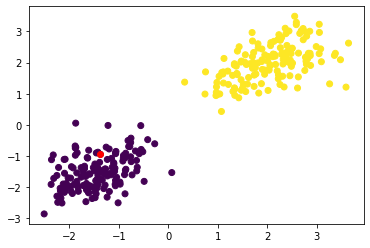

In [ ]:
chosen_point = x_train[3]
plt.scatter(x_train.T[0], x_train.T[1], c=indices)
plt.scatter(*chosen_point.T, color='red')

plt.show()

In [ ]:
revisor = Revise(classifier, vae)

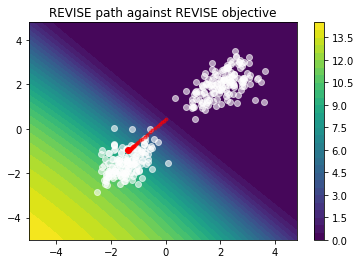

In [ ]:
path = revisor.shortest_path_to_target_class(chosen_point, learning_rate=1e-3, max_iter=500)
revisor.show_path(path, x_train)

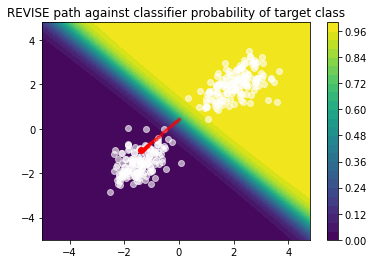

In [ ]:
revisor.show_path(path, x_train, landscape='prob_target')

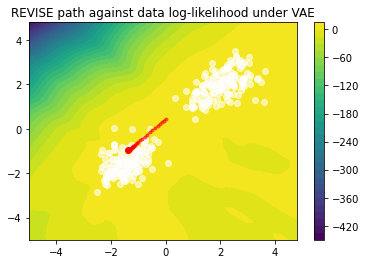

In [ ]:
revisor.show_path(path, x_train, landscape='likelihood')

In [ ]:
g, positions = revisor._grid_positions()

In [ ]:
reconstructed_x = vae.decode(vae.encode(positions)[:,:2])

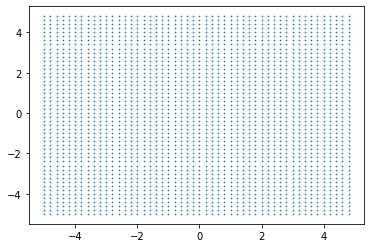

In [ ]:
plt.scatter(positions[:,0], positions[:,1], marker='.', s=2)

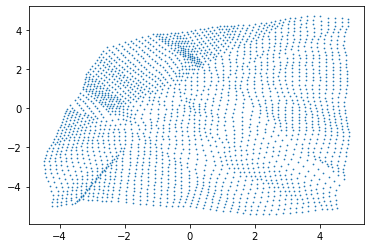

In [ ]:
plt.scatter(reconstructed_x[:,0], reconstructed_x[:,1], marker='.', s=2)

In [ ]:
np.linalg.norm(positions - reconstructed_x, axis=1)

array([0.7635987 , 0.77663803, 0.79000586, ..., 0.18591115, 0.22009781,
       0.22265555], dtype=float32)

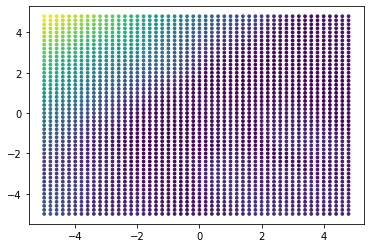

In [ ]:
plt.scatter(positions[:,0], positions[:,1], marker='.', s=30, c=np.linalg.norm(positions - reconstructed_x, axis=1))

## Moons Dataset

In [ ]:
import sklearn.datasets

In [ ]:
x, y = sklearn.datasets.make_moons(300, noise=0.1)

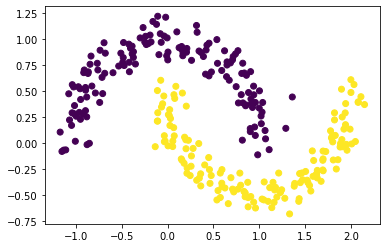

In [ ]:
plt.scatter(x[:,0], x[:,1], c=y)

In [ ]:
data = (x, y.reshape(-1, 1))
rng_key = random.PRNGKey(0)
# We're not batching anything, so shapes of inputs and outputs are just shapes of data
input_dim = 2
output_dim = 1
hidden_widths = [100]
init_model, predict = create_mlp(hidden_widths, Relu, output_dim, Sigmoid)
output_shape, start_params = init_model(rng_key, (-1, input_dim))
(min_loss, fit_params), history = fit(predict, binary_crossentropy_loss, start_params, data, step_size=1e-2, max_iter=200)
classifier = Classifier(partial(predict, fit_params))

In [ ]:
rng_key = random.PRNGKey(0)
data = x_train
data_vari = x_var

enc_input_dim = 2
latent_dim = 2
hidden_widths = [50]
init_model, encode = create_mlp(hidden_widths, Relu, latent_dim * 2)
enc_output_shape, enc_start_params = init_model(rng_key, (-1, enc_input_dim))

dec_input_dim = 2
dec_output_dim = 2
hidden_widths = [50]
init_model, decode = create_mlp(hidden_widths, Relu, dec_output_dim)
dec_output_shape, dec_start_params = init_model(rng_key, (-1, dec_input_dim))

In [ ]:
model = (encode, decode)
start_params = (enc_start_params, dec_start_params)
(min_loss, fit_params), history = fit_vae(rng_key, model, start_params, 
                              data, data_vari, step_size=1e-2, max_iter=5000)
vae = VAE(partial(encode, fit_params[0]), 
          partial(decode, fit_params[1]), latent_dim, x_var)

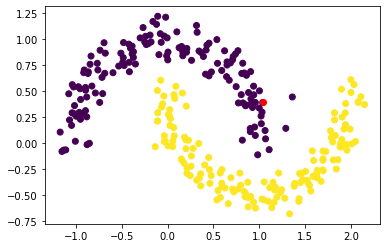

In [ ]:
chosen_point = x[1,:]
plt.scatter(x[:,0], x[:,1], c=y)
plt.scatter(*chosen_point, color='red')

plt.show()

In [ ]:
revisor = Revise(classifier, vae)

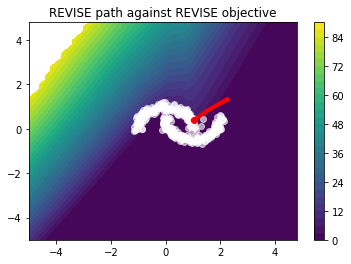

In [ ]:
path = revisor.shortest_path_to_target_class(chosen_point, learning_rate=1e-3, max_iter=500)
revisor.show_path(path, x)

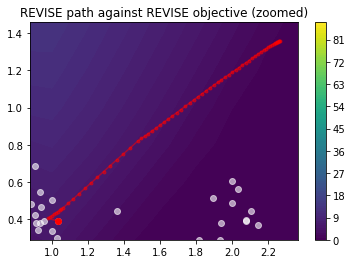

In [ ]:
path = revisor.shortest_path_to_target_class(chosen_point, learning_rate=1e-3, max_iter=500)
revisor.show_path(path, x, zoom=True)

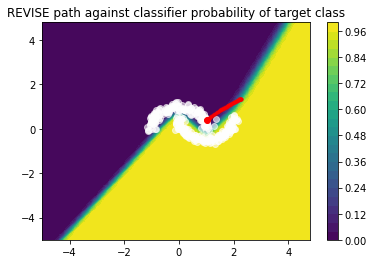

In [ ]:
revisor.show_path(path, x, landscape='prob_target')

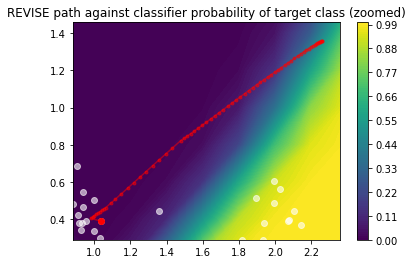

In [ ]:
revisor.show_path(path, x, landscape='prob_target', zoom=True)

## Circles

In [ ]:
x, y = sklearn.datasets.make_circles(n_samples=300, factor=.5,
                                      noise=.05)

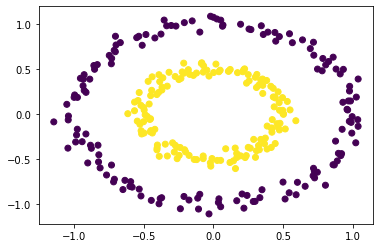

In [ ]:
plt.scatter(x[:,0], x[:,1], c=y)

In [ ]:
data = (x, y.reshape(-1, 1))
rng_key = random.PRNGKey(0)
# We're not batching anything, so shapes of inputs and outputs are just shapes of data
input_dim = 2
output_dim = 1
hidden_widths = [100]
init_model, predict = create_mlp(hidden_widths, Relu, output_dim, Sigmoid)
output_shape, start_params = init_model(rng_key, (-1, input_dim))
(min_loss, fit_params), history = fit(predict, binary_crossentropy_loss, start_params, data, step_size=1e-2, max_iter=200)
classifier = Classifier(partial(predict, fit_params))

In [ ]:
rng_key = random.PRNGKey(0)
data = x_train
data_vari = x_var

enc_input_dim = 2
latent_dim = 2
hidden_widths = [50]
init_model, encode = create_mlp(hidden_widths, Relu, latent_dim * 2)
enc_output_shape, enc_start_params = init_model(rng_key, (-1, enc_input_dim))

dec_input_dim = 2
dec_output_dim = 2
hidden_widths = [50]
init_model, decode = create_mlp(hidden_widths, Relu, dec_output_dim)
dec_output_shape, dec_start_params = init_model(rng_key, (-1, dec_input_dim))

In [ ]:
model = (encode, decode)
start_params = (enc_start_params, dec_start_params)
(min_loss, fit_params), history = fit_vae(rng_key, model, start_params, 
                              data, data_vari, step_size=1e-2, max_iter=5000)
vae = VAE(partial(encode, fit_params[0]), 
          partial(decode, fit_params[1]), latent_dim, x_var)

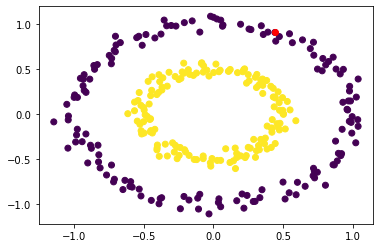

In [ ]:
chosen_point = x[1,:]
plt.scatter(x[:,0], x[:,1], c=y)
plt.scatter(*chosen_point, color='red')

plt.show()

In [ ]:
revisor = Revise(classifier, vae)

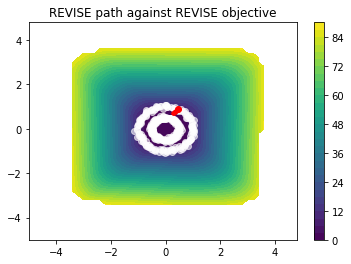

In [ ]:
path = revisor.shortest_path_to_target_class(chosen_point, learning_rate=1e-5, max_iter=500)
revisor.show_path(path, x)

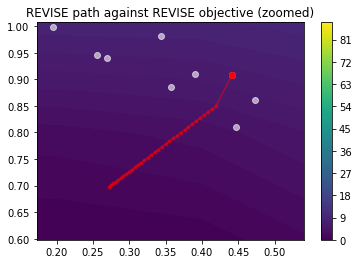

In [ ]:
revisor.show_path(path, x, zoom=True)

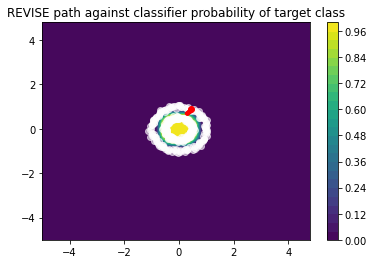

In [ ]:
revisor.show_path(path, x, landscape='prob_target')

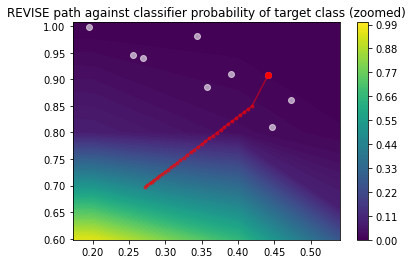

In [ ]:
revisor.show_path(path, x, landscape='prob_target', zoom=True)

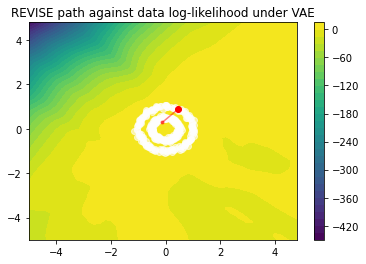

In [ ]:
revisor.show_path(path, x, landscape='likelihood', zoom=False)